In [2]:
pip install deap

In [3]:
!git clone https://github.com/anyoptimization/pymoo
!cd pymoo && pip install .

Cloning into 'pymoo'...
remote: Enumerating objects: 12335, done.
remote: Counting objects: 100% (2890/2890), done.
remote: Compressing objects: 100% (930/930), done.
remote: Total 12335 (delta 2184), reused 2310 (delta 1950), pack-reused 9445 (from 1)
Receiving objects: 100% (12335/12335), 18.37 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (7760/7760), done.
Processing /content/pymoo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.6 MB/s eta 0:00:00
  Created wheel for pymoo: fil

In [21]:
import math

import numpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as cm
import matplotlib.pyplot as plt
from deap import benchmarks
import numpy as np
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.core.individual import Individual

from pymoo.core.crossover import Crossover
from pymoo.core.variable import Real, get
from pymoo.operators.repair.bounds_repair import repair_clamp

In [22]:
def dynamic_xu_xl(model_keys) :
    assert len(model_keys) == 4
    xu = []
    xl = []
    for model_key in model_keys:
        match model_key:
            case 0:
                xl.extend([2, 0])
                xu.extend([16, 0])
            case 1:
                xl.extend([4, 1])
                xu.extend([8, 8])
            case 2:
                xl.extend([1, 0])
                xu.extend([28, 0])
            case 3:
                xl.extend([2, 2])
                xu.extend([6, 3])
            case 4:
                xl.extend([4, 0])
                xu.extend([16, 0])
            case 5:
                xl.extend([4, 1])
                xu.extend([8, 8])
            case 6:
                xl.extend([1, 1])
                xu.extend([3, 4])
            case 7:
                xl.extend([2, 2])
                xu.extend([16, 16])
            case 8:
                xl.extend([4, 0])
                xu.extend([8, 0])

    return np.array(xl), np.array(xu)


In [23]:
class CustomIntegerRandomSampling(Sampling):
    def __init__(self):
        super().__init__()

    def _do(self, problem, n_samples, **kwargs):
        n = int(problem.n_var / 3)
        xl, xu = problem.bounds()
        xl = xl[0:n]
        xu = xu[0:n]
        X = np.column_stack([np.random.randint(xl[k], xu[k] + 1, size=n_samples) for k in range(n)])
        full_solution = np.zeros((n_samples, problem.n_var))
        full_solution[:, :n] = X

        for i in range(n_samples):
            Dxl, Dxu = dynamic_xu_xl(X[i])
            dynamic_params = np.array([np.random.randint(Dxl[k], Dxu[k] + 1) for k in range(2*n)])
            full_solution[i, n:] = dynamic_params

        # Convert full_solution to array of Individuals using frompyfunc
        individuals = np.array([Individual(X=x) for x in full_solution])
        return individuals

In [24]:
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask
import numpy as np


class UniformCrossoverv(Crossover):

    def __init__(self,
                 prob_var=1.0,
                 eta=15,
                 prob_exch=1.0,
                 prob_bin=0.5,
                 n_offsprings=1,
                 **kwargs):
        super().__init__(2, 1, **kwargs)
        self.prob_var = Real(prob_var, bounds=(0.1, 0.9))
        self.eta = Real(eta, bounds=(3.0, 30.0), strict=(1.0, None))
        self.prob_exch = Real(prob_exch, bounds=(0.0, 1.0), strict=(0.0, 1.0))
        self.prob_bin = Real(prob_bin, bounds=(0.0, 1.0), strict=(0.0, 1.0))

    def _do(self, _, X, **kwargs):
        _, n_matings, n_var = X.shape
        n_var /= 3
        n_var = int(n_var)
        X_model_conf = X[:, :, :4]
        X_model_params = X[:, :, 4:]
        M = np.random.random((n_matings, n_var)) < 0.5
        _X_model_conf = crossover_mask(X_model_conf, M)
        xl_mat, xu_mat = np.empty((0, n_var * 2)), np.empty((0, n_var * 2))
        if self.n_offsprings == 1:
            rand = np.random.random(size=n_matings) < 0.5
            _X_model_conf[0, rand] = _X_model_conf[1, rand]
            _X_model_conf = _X_model_conf[[0]]
        for t in _X_model_conf :
            for conf in t:
                dynamic_xl, dynamic_xu = dynamic_xu_xl(conf)
                xl_mat = np.vstack([xl_mat, dynamic_xl])
                xu_mat = np.vstack([xu_mat, dynamic_xu])


        _, n_matings, _ = X_model_params.shape
        n_var *= 3
        # get the parameters required by SBX
        eta, prob_var, prob_exch, prob_bin = get(self.eta, self.prob_var, self.prob_exch, self.prob_bin, size=(n_matings, 1))

        # set the binomial probability to zero if no exchange between individuals shall happen
        rand = np.random.random((len(prob_bin), 1))
        prob_bin[rand > prob_exch] = 0.0
        print("shape")
        print(xl_mat.shape)
        Q = cross_sbx(X_model_params.astype(float), xl_mat, xu_mat, eta, prob_var, prob_bin)

        if self.n_offsprings == 1:
            rand = np.random.random(size=n_matings) < 0.5
            Q[0, rand] = Q[1, rand]
            Q = Q[[0]]

        print("LOLL")
        print(_X_model_conf.shape, Q.shape)
        return np.concatenate((_X_model_conf, Q), axis=-1)


def cross_sbx(X, xl, xu, eta, prob_var, prob_bin, eps=1.0e-14):
    n_parents, n_matings, n_var = X.shape

    # the probability of a crossover for each of the variables
    cross = np.random.random((n_matings, n_var)) < prob_var

    # when solutions are too close -> do not apply sbx crossover
    too_close = np.abs(X[0] - X[1]) <= eps

    # disable if two individuals are already too close
    cross[too_close] = False

    # disable crossover when lower and upper bound are identical
    # cross[:, xl == xu] = False

    # assign y1 the smaller and y2 the larger value
    y1 = np.min(X, axis=0)[cross]
    y2 = np.max(X, axis=0)[cross]

    # mask all the values that should be crossovered
    print("xl")
    print(xl.shape, cross.shape)
    _xl = xl[cross]
    _xu = xu[cross]
    eta = eta.repeat(n_var, axis=1)[cross]
    prob_bin = prob_bin.repeat(n_var, axis=1)[cross]
    print(np.repeat(xl[None, :], n_matings, axis=0))
    # random values for each individual
    rand = np.random.random(len(eta))

    def calc_betaq(beta):
        epsilon = 1e-8  # A small value to avoid division by zero
        alpha = 2.0 - np.power(np.maximum(beta, epsilon), -(eta + 1.0))

        mask, mask_not = (rand <= (1.0 / alpha)), (rand > (1.0 / alpha))

        betaq = np.zeros(mask.shape)
        betaq[mask] = np.power(np.maximum((rand * alpha), 0.0), (1.0 / (eta + 1.0)))[mask]
        betaq[mask_not] = np.power((1.0 / (2.0 - rand * alpha)), (1.0 / (eta + 1.0)))[mask_not]

        return betaq

    # difference between all variables
    delta = (y2 - y1)

    beta = 1.0 + (2.0 * (y1 - _xl) / delta)
    betaq = calc_betaq(beta)
    c1 = 0.5 * ((y1 + y2) - betaq * delta)

    beta = 1.0 + (2.0 * (_xu - y2) / delta)
    betaq = calc_betaq(beta)
    c2 = 0.5 * ((y1 + y2) + betaq * delta)

    # with the given probability either assign the value from the first or second parent
    b = np.random.random(len(prob_bin)) < prob_bin
    tmp = np.copy(c1[b])
    c1[b] = c2[b]
    c2[b] = tmp

    # first copy the unmodified parents
    Q = np.copy(X)

    # copy the positions where the crossover was done
    Q[0, cross] = c1
    Q[1, cross] = c2

    Q[0] = repair_clamp(Q[0], xl, xu)
    Q[1] = repair_clamp(Q[1], xl, xu)

    return Q


In [25]:
def repair_clamp(Xp, xl, xu):

    I = np.where(Xp < xl)
    c = np.sum(Xp < xl)
    Xp[I] = xl[I]

    I = np.where(Xp > xu)
    c += np.sum(Xp > xu)
    Xp[I] = xu[I]
    print("lolcount")
    print(c)
    print(Xp.shape)
    return Xp

In [26]:
#cur
n_var, n_matings = 12, 30

problem = Problem(n_var=12, n_obj=2, xl=[0, 0, 0, 0, -2, -2, -2, -2, -2, -2, -2, -2], xu=[8, 8, 8, 8, -2, -2, -2, -2, -2, -2, -2, -2])

sampler = CustomIntegerRandomSampling()
pop1 = sampler._do(problem, 30)

pop2 = sampler._do(problem, 30)

parent = [[a, b] for a, b in zip(pop1, pop2)]

off = UniformCrossoverv(prob=1.0, eta = 1).do(problem, parent)
Xp = off.get("X")

shape
(30, 8)
xl
(30, 8) (30, 8)
[[[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1. 1. 4. ... 1. 1. 0.]]

 [[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1. 1. 4. ... 1. 1. 0.]]

 [[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1. 1. 4. ... 1. 1. 0.]]

 ...

 [[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1. 1. 4. ... 1. 1. 0.]]

 [[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1. 1. 4. ... 1. 1. 0.]]

 [[1. 0. 4. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 2. 0.]
  [2. 2. 1. ... 2. 2. 2.]
  ...
  [4. 0. 1. ... 2. 4. 1.]
  [2. 0. 4. ... 0. 1. 1.]
  [1.

In [27]:
print(Xp)

[[ 2.          4.          3.          1.          3.79919901  0.
  12.68863739  0.          4.7348504   2.          8.          5.01499929]
 [ 0.          4.          0.          0.          5.67020546  0.
  13.60636642  0.          4.02412304  0.         14.22201762  0.        ]
 [ 7.          6.          7.          3.          6.         11.25643161
   3.          2.627287   13.95105034  5.57701803  2.          2.        ]
 [ 2.          3.          1.          7.          6.17093668  0.
   6.          2.72443982  4.73780581  2.46676279  3.0219569   8.45976527]
 [ 0.          1.          6.          5.          2.          0.
   8.          7.6172538   3.          1.          4.00287844  2.41352382]
 [ 6.          4.          1.          5.          3.          1.20803309
   5.06086057  0.          7.80683995  1.9367039   8.          7.96096312]
 [ 4.          4.          2.          0.          4.          0.
   7.60947118  0.         24.96991392  0.          4.29668868  0.       

In [28]:
def bitflip_mutation_dynamic(Xp, mutation_prob=0.1):
    """
    Perform bitflip mutation on the offspring while adhering to dynamic bounds.

    Parameters:
    - Xp: np.array, the offspring population (n_offsprings, n_var).
    - mutation_prob: float, probability of flipping each gene.

    Returns:
    - mutated_offsprings: np.array, mutated population of the same size as Xp.
    """
    # Clone the offspring to mutate without altering the original
    mutated_offsprings = Xp.copy()
    n_offsprings, n_var = Xp.shape
    n_model_keys = 4  # First 4 genes are model keys

    # Iterate over each offspring
    for i in range(n_offsprings):
        # Mutate the model keys (first 4 genes)
        for j in range(n_model_keys):
            if np.random.random() < mutation_prob:
                xl, xu = problem.xl[j], problem.xu[j]
                mutated_offsprings[i, j] = np.random.randint(xl, xu + 1)

        # Fetch the mutated model keys
        model_keys = mutated_offsprings[i, :n_model_keys].astype(int)

        # Get dynamic bounds for parameters
        dynamic_xl, dynamic_xu = dynamic_xu_xl(model_keys)

        # Mutate the parameters (remaining genes)
        for j, (xl, xu) in enumerate(zip(dynamic_xl, dynamic_xu), start=n_model_keys):
            if np.random.random() < mutation_prob:
                mutated_offsprings[i, j] = np.random.randint(xl, xu + 1)

    return mutated_offsprings


# Mutation probability can be adjusted (e.g., 0.1 means 10% chance of flipping each gene)
mutation_prob = 0.1

# Apply bitflip mutation with dynamic bounds
mutated_Xp = bitflip_mutation_dynamic(Xp, mutation_prob)

# Print the mutated offsprings
print("Mutated Offsprings:")
print(mutated_Xp)



Mutated Offsprings:
[[ 2.          4.          3.          1.          3.79919901  0.
  12.68863739  0.          4.7348504   2.          8.          5.01499929]
 [ 0.          4.          0.          0.         15.          0.
  13.60636642  0.          8.          0.         14.22201762  0.        ]
 [ 7.          6.          7.          3.          6.         11.25643161
   1.          2.627287   13.95105034  5.57701803  2.          2.        ]
 [ 2.          3.          3.          7.          6.17093668  0.
   6.          3.          4.73780581  2.46676279  3.0219569   8.45976527]
 [ 0.          1.          6.          1.          2.          0.
   8.          8.          3.          1.          4.00287844  2.41352382]
 [ 6.          4.          1.          5.          3.          1.20803309
   5.06086057  0.          7.80683995  1.9367039   4.          7.96096312]
 [ 4.          4.          2.          0.          4.          0.
   7.60947118  0.         24.96991392  0.          4

In [29]:
# Step 3: Round mutated offspring to the nearest integer
mutated_Xp = [np.round(offspring).astype(int).tolist() for offspring in mutated_Xp]

# Print the mutated offsprings
print("Rounded Mutated Offsprings:")
print(mutated_Xp)

Rounded Mutated Offsprings:
[[2, 4, 3, 1, 4, 0, 13, 0, 5, 2, 8, 5], [0, 4, 0, 0, 15, 0, 14, 0, 8, 0, 14, 0], [7, 6, 7, 3, 6, 11, 1, 3, 14, 6, 2, 2], [2, 3, 3, 7, 6, 0, 6, 3, 5, 2, 3, 8], [0, 1, 6, 1, 2, 0, 8, 8, 3, 1, 4, 2], [6, 4, 1, 5, 3, 1, 5, 0, 8, 2, 4, 8], [4, 4, 2, 0, 4, 0, 8, 0, 25, 0, 4, 0], [7, 5, 0, 8, 2, 2, 8, 8, 12, 0, 4, 0], [8, 4, 4, 6, 6, 0, 4, 0, 16, 0, 3, 2], [4, 6, 7, 2, 10, 0, 3, 3, 7, 11, 21, 0], [0, 8, 1, 3, 14, 0, 7, 0, 5, 3, 6, 2], [0, 6, 2, 3, 5, 0, 3, 2, 13, 0, 2, 2], [1, 2, 5, 2, 8, 6, 3, 0, 5, 0, 11, 0], [0, 0, 6, 0, 8, 0, 5, 0, 3, 3, 12, 0], [8, 7, 1, 3, 8, 0, 8, 14, 4, 1, 6, 2], [7, 4, 4, 8, 10, 10, 6, 0, 9, 0, 5, 0], [0, 3, 6, 5, 9, 0, 5, 3, 3, 4, 4, 4], [0, 7, 4, 2, 16, 0, 4, 2, 6, 0, 12, 0], [4, 2, 0, 8, 4, 0, 1, 0, 9, 0, 7, 0], [6, 1, 3, 3, 3, 4, 4, 5, 2, 0, 6, 3], [3, 0, 4, 7, 4, 8, 6, 0, 4, 0, 6, 2], [6, 3, 1, 2, 2, 1, 5, 2, 6, 2, 4, 0], [2, 7, 3, 1, 6, 0, 13, 2, 5, 2, 5, 4], [2, 4, 5, 6, 18, 0, 8, 0, 5, 1, 3, 4], [4, 0, 6, 0, 8, 0, 14, 0, 3, 1, 7, 0

In [30]:
def validate_offspring_with_repeated_models(offspring, dynamic_xu_xl):
    """
    Validate offspring by detecting repeated models and adjusting parameters
    based on the specified rules.

    Parameters:
    - offspring: List[int], the mutated offspring (models + parameters).
    - dynamic_xu_xl: Function, returns dynamic bounds based on model keys.

    Returns:
    - validated_offspring: List[int], offspring after validation.
    """
    # Extract models and parameters
    model_keys = offspring[:4]
    parameters = offspring[4:]

    # Get dynamic bounds based on the model keys
    dynamic_xl, dynamic_xu = dynamic_xu_xl(model_keys)

    # Detect repeated models
    unique_models = {}
    for idx, model in enumerate(model_keys):
        if model not in unique_models:
            unique_models[model] = []
        unique_models[model].append(idx)

    # Process repeated models
    for model, indices in unique_models.items():
        if len(indices) > 1:  # Only process if model is repeated
            # Collect the parameters associated with each repeated instance
            repeated_params = [parameters[i * 2:(i + 1) * 2] for i in indices]

            # Compare and update parameters
            max_params = repeated_params[0]  # Start with the first instance's parameters
            for i in range(1, len(repeated_params)):
                current_params = repeated_params[i]
                updated_params = []

                for max_p, current_p, xl, xu in zip(max_params, current_params, dynamic_xl, dynamic_xu):
                    # If the current parameter is less than or equal to the max, update it
                    if current_p <= max_p:
                        updated_params.append(min(max_p + 1, xu))  # Ensure within bounds
                    else:
                        updated_params.append(current_p)  # Keep as is if valid

                # Update the offspring with the new parameters
                parameters[indices[i] * 2:(indices[i] + 1) * 2] = updated_params
                max_params = updated_params  # Update max_params for next comparison

    # Combine models and validated parameters back into a single array
    return model_keys + parameters


# Example Usage
offspring =  [5, 5, 0, 5, 6, 3, 4, 3, 4, 0, 7, 1]
  # Example offspring with repeated models
validated_offspring = validate_offspring_with_repeated_models(offspring, dynamic_xu_xl)

print("Validated Offspring:")
print(validated_offspring)


Validated Offspring:
[5, 5, 0, 5, 6, 3, 7, 4, 4, 0, 8, 5]


In [31]:
import numpy as np

def validate_offspring_with_repeated_models(offspring, dynamic_xu_xl):
    """
    Validate offspring by detecting repeated models and adjusting parameters
    based on the specified rules.

    Parameters:
    - offspring: List[int], the mutated offspring (models + parameters).
    - dynamic_xu_xl: Function, returns dynamic bounds based on model keys.

    Returns:
    - validated_offspring: List[int], offspring after validation.
    """
    # Extract models and parameters
    model_keys = offspring[:4]
    parameters = offspring[4:]

    # Get dynamic bounds based on the model keys
    dynamic_xl, dynamic_xu = dynamic_xu_xl(model_keys)

    # Detect repeated models
    unique_models = {}
    for idx, model in enumerate(model_keys):
        if model not in unique_models:
            unique_models[model] = []
        unique_models[model].append(idx)

    # Process repeated models
    for model, indices in unique_models.items():
        if len(indices) > 1:  # Only process if model is repeated
            # Collect the parameters associated with each repeated instance
            repeated_params = [parameters[i * 2:(i + 1) * 2] for i in indices]

            # Compare and update parameters
            max_params = repeated_params[0]  # Start with the first instance's parameters
            for i in range(1, len(repeated_params)):
                current_params = repeated_params[i]
                updated_params = []

                for max_p, current_p, xl, xu in zip(max_params, current_params, dynamic_xl, dynamic_xu):
                    # If the current parameter is less than or equal to the max, update it
                    if current_p <= max_p:
                        updated_params.append(min(max_p + 1, xu))  # Ensure within bounds
                    else:
                        updated_params.append(current_p)  # Keep as is if valid

                # Update the offspring with the new parameters
                parameters[indices[i] * 2:(indices[i] + 1) * 2] = updated_params
                max_params = updated_params  # Update max_params for next comparison

    # Combine models and validated parameters back into a single array
    return model_keys + parameters

# Step 3: Round mutated offspring to the nearest integer
mutated_Xp = [np.round(offspring).astype(int).tolist() for offspring in mutated_Xp]

# Print the rounded mutated offsprings
print("Rounded Mutated Offsprings:")
for offspring in mutated_Xp:
    print(offspring)

# Step 4: Apply semantic validation to the rounded offsprings
validated_offsprings = [validate_offspring_with_repeated_models(offspring, dynamic_xu_xl) for offspring in mutated_Xp]

# Print the validated offsprings after rounding
print("\nValidated Offsprings after Rounding and Validation:")
for validated in validated_offsprings:
    print(validated)


Rounded Mutated Offsprings:
[2, 4, 3, 1, 4, 0, 13, 0, 5, 2, 8, 5]
[0, 4, 0, 0, 15, 0, 14, 0, 8, 0, 14, 0]
[7, 6, 7, 3, 6, 11, 1, 3, 14, 6, 2, 2]
[2, 3, 3, 7, 6, 0, 6, 3, 5, 2, 3, 8]
[0, 1, 6, 1, 2, 0, 8, 8, 3, 1, 4, 2]
[6, 4, 1, 5, 3, 1, 5, 0, 8, 2, 4, 8]
[4, 4, 2, 0, 4, 0, 8, 0, 25, 0, 4, 0]
[7, 5, 0, 8, 2, 2, 8, 8, 12, 0, 4, 0]
[8, 4, 4, 6, 6, 0, 4, 0, 16, 0, 3, 2]
[4, 6, 7, 2, 10, 0, 3, 3, 7, 11, 21, 0]
[0, 8, 1, 3, 14, 0, 7, 0, 5, 3, 6, 2]
[0, 6, 2, 3, 5, 0, 3, 2, 13, 0, 2, 2]
[1, 2, 5, 2, 8, 6, 3, 0, 5, 0, 11, 0]
[0, 0, 6, 0, 8, 0, 5, 0, 3, 3, 12, 0]
[8, 7, 1, 3, 8, 0, 8, 14, 4, 1, 6, 2]
[7, 4, 4, 8, 10, 10, 6, 0, 9, 0, 5, 0]
[0, 3, 6, 5, 9, 0, 5, 3, 3, 4, 4, 4]
[0, 7, 4, 2, 16, 0, 4, 2, 6, 0, 12, 0]
[4, 2, 0, 8, 4, 0, 1, 0, 9, 0, 7, 0]
[6, 1, 3, 3, 3, 4, 4, 5, 2, 0, 6, 3]
[3, 0, 4, 7, 4, 8, 6, 0, 4, 0, 6, 2]
[6, 3, 1, 2, 2, 1, 5, 2, 6, 2, 4, 0]
[2, 7, 3, 1, 6, 0, 13, 2, 5, 2, 5, 4]
[2, 4, 5, 6, 18, 0, 8, 0, 5, 1, 3, 4]
[4, 0, 6, 0, 8, 0, 14, 0, 3, 1, 7, 0]
[5, 2, 1, 7, 4, 6, 10, 

In [32]:
# Round mutated offspring to the nearest integer
mutated_Xp = [np.round(offspring).astype(int).tolist() for offspring in mutated_Xp]

# Apply the semantic validation to each offspring
validated_mutated_Xp = [validate_offspring_with_repeated_models(offspring, dynamic_xu_xl) for offspring in mutated_Xp]

# Print the validated offspring
print("Validated Offsprings after Rounding and Validation:")
print(validated_mutated_Xp)


Validated Offsprings after Rounding and Validation:
[[2, 4, 3, 1, 4, 0, 13, 0, 5, 2, 8, 5], [0, 4, 0, 0, 15, 0, 14, 0, 16, 0, 16, 0], [7, 6, 7, 3, 6, 11, 1, 3, 14, 12, 2, 2], [2, 3, 3, 7, 6, 0, 6, 3, 7, 0, 3, 8], [0, 1, 6, 1, 2, 0, 8, 8, 3, 1, 9, 0], [6, 4, 1, 5, 3, 1, 5, 0, 8, 2, 4, 8], [4, 4, 2, 0, 4, 0, 8, 0, 25, 0, 4, 0], [7, 5, 0, 8, 2, 2, 8, 8, 12, 0, 4, 0], [8, 4, 4, 6, 6, 0, 4, 0, 16, 0, 3, 2], [4, 6, 7, 2, 10, 0, 3, 3, 7, 11, 21, 0], [0, 8, 1, 3, 14, 0, 7, 0, 5, 3, 6, 2], [0, 6, 2, 3, 5, 0, 3, 2, 13, 0, 2, 2], [1, 2, 5, 2, 8, 6, 3, 0, 5, 0, 11, 1], [0, 0, 6, 0, 8, 0, 9, 0, 3, 3, 12, 0], [8, 7, 1, 3, 8, 0, 8, 14, 4, 1, 6, 2], [7, 4, 4, 8, 10, 10, 6, 0, 9, 1, 5, 0], [0, 3, 6, 5, 9, 0, 5, 3, 3, 4, 4, 4], [0, 7, 4, 2, 16, 0, 4, 2, 6, 0, 12, 0], [4, 2, 0, 8, 4, 0, 1, 0, 9, 0, 7, 0], [6, 1, 3, 3, 3, 4, 4, 5, 2, 0, 6, 3], [3, 0, 4, 7, 4, 8, 6, 0, 4, 0, 6, 2], [6, 3, 1, 2, 2, 1, 5, 2, 6, 2, 4, 0], [2, 7, 3, 1, 6, 0, 13, 2, 5, 2, 5, 4], [2, 4, 5, 6, 18, 0, 8, 0, 5, 1, 3, 4], [4, 0, 6, 

In [33]:
print("Number of validated offsprings:", len(validated_mutated_Xp))
for i, offspring in enumerate(validated_mutated_Xp):
    print(f"Offspring {i+1}: {offspring}")


Number of validated offsprings: 30
Offspring 1: [2, 4, 3, 1, 4, 0, 13, 0, 5, 2, 8, 5]
Offspring 2: [0, 4, 0, 0, 15, 0, 14, 0, 16, 0, 16, 0]
Offspring 3: [7, 6, 7, 3, 6, 11, 1, 3, 14, 12, 2, 2]
Offspring 4: [2, 3, 3, 7, 6, 0, 6, 3, 7, 0, 3, 8]
Offspring 5: [0, 1, 6, 1, 2, 0, 8, 8, 3, 1, 9, 0]
Offspring 6: [6, 4, 1, 5, 3, 1, 5, 0, 8, 2, 4, 8]
Offspring 7: [4, 4, 2, 0, 4, 0, 8, 0, 25, 0, 4, 0]
Offspring 8: [7, 5, 0, 8, 2, 2, 8, 8, 12, 0, 4, 0]
Offspring 9: [8, 4, 4, 6, 6, 0, 4, 0, 16, 0, 3, 2]
Offspring 10: [4, 6, 7, 2, 10, 0, 3, 3, 7, 11, 21, 0]
Offspring 11: [0, 8, 1, 3, 14, 0, 7, 0, 5, 3, 6, 2]
Offspring 12: [0, 6, 2, 3, 5, 0, 3, 2, 13, 0, 2, 2]
Offspring 13: [1, 2, 5, 2, 8, 6, 3, 0, 5, 0, 11, 1]
Offspring 14: [0, 0, 6, 0, 8, 0, 9, 0, 3, 3, 12, 0]
Offspring 15: [8, 7, 1, 3, 8, 0, 8, 14, 4, 1, 6, 2]
Offspring 16: [7, 4, 4, 8, 10, 10, 6, 0, 9, 1, 5, 0]
Offspring 17: [0, 3, 6, 5, 9, 0, 5, 3, 3, 4, 4, 4]
Offspring 18: [0, 7, 4, 2, 16, 0, 4, 2, 6, 0, 12, 0]
Offspring 19: [4, 2, 0, 8, 4, 0, 

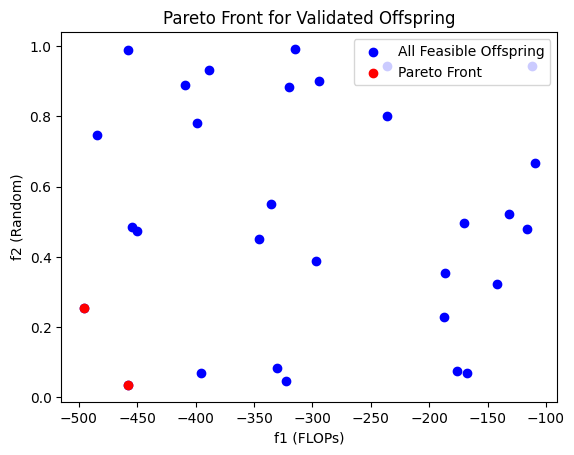

Fitness Values (f1, f2):
(-236.52314151702257, 0.9428311414132617)
(-176.44661534546879, 0.07641685943805143)
(-388.2529144261134, 0.9303188848378237)
(-398.7766268796862, 0.7811704237869193)
(-169.94712162851846, 0.4954521034609818)
(-345.4604360606738, 0.45012443241975963)
(-409.2141222538543, 0.8893909161288442)
(-319.75213730809685, 0.8824594404560998)
(-457.7226080374904, 0.9882752710001314)
(-322.6907650225527, 0.04783082039410547)
(-484.79126070501803, 0.7462072574818386)
(-236.38578631852766, 0.8021305581275875)
(-457.8529864188776, 0.03557086703554835)
(-296.5682842209686, 0.38759523148276953)
(-315.2212253316177, 0.991588408870274)
(-111.70001693173191, 0.9423153896731928)
(-186.46292929293048, 0.3548413602568904)
(-335.14762789489134, 0.5496160437189245)
(-167.78621743806406, 0.06871283251826776)
(-330.28124564604474, 0.08261766345926869)
(-294.13696537059536, 0.8989008240062354)
(-187.00603017442484, 0.22784241754310997)
(-109.603660160483, 0.6673503980464284)
(-495.8289202

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the objective functions
def f1(offspring):
    """Objective 1: Random FLOPs value in [-500, -100]."""
    return np.random.uniform(-500, -100)

def f2(offspring):
    """Objective 2: Random value in [0, 1]."""
    return np.random.uniform(0, 1)

# Step 2: Compute fitness values for validated offsprings
fitness = []
for offspring in validated_mutated_Xp:
    f1_value = f1(offspring)
    f2_value = f2(offspring)
    fitness.append((f1_value, f2_value))

# Step 3: Identify the Pareto front
def pareto_front(fitness):
    """Identify Pareto front from a set of fitness values."""
    pareto = []
    for i, f in enumerate(fitness):
        dominated = False
        for j, other in enumerate(fitness):
            if j != i and other[0] <= f[0] and other[1] <= f[1] and (other[0] < f[0] or other[1] < f[1]):
                dominated = True
                break
        if not dominated:
            pareto.append(f)
    return pareto

pareto = pareto_front(fitness)

# Step 4: Visualization of Pareto front
if fitness:
    f1_vals = [f[0] for f in fitness]
    f2_vals = [f[1] for f in fitness]
    pareto_f1 = [p[0] for p in pareto]
    pareto_f2 = [p[1] for p in pareto]

    plt.scatter(f1_vals, f2_vals, label="All Feasible Offspring", color="blue")
    plt.scatter(pareto_f1, pareto_f2, label="Pareto Front", color="red")
    plt.xlabel("f1 (FLOPs)")
    plt.ylabel("f2 (Random)")
    plt.legend()
    plt.title("Pareto Front for Validated Offspring")
    plt.show()
else:
    print("No feasible solutions found.")

print("Fitness Values (f1, f2):")
for f in fitness:
    print(f)

print("\nPareto Front:")
for p in pareto:
    print(p)
